# **VR EEG Emotion Classification**

# **1. Importing Library and Dataset**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize, RobustScaler
from sklearn.metrics import (
    auc,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
 )
from sklearn.svm import LinearSVC, SVC
from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf
from keras import Sequential, Model
from keras.layers import (
    Add,
    LSTM,
    Input,
    Dense,
    Layer,
    Conv1D,
    Conv2D,
    Flatten,
    Dropout,
    Reshape,
    Activation,
    SimpleRNN,
    Embedding,
    Bidirectional,
    DepthwiseConv2D,
    SeparableConv2D,
    AveragePooling2D,
    LayerNormalization,
    MultiHeadAttention,
    BatchNormalization,
    GlobalAveragePooling1D,
 )
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.regularizers import l2

In [72]:
csvfile = pd.read_csv('dataset.csv')

# **2. Exploratory Data Analysis (EDA)**

## 2.1 Data Cleaning and Missing/Error Values

### 2.1.1 Understanding the dataset

Understanding the dimensions and finding out errors.

***Dataset***

In [74]:
csvfile

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,p1,Calm,848.16850,838.49817,861.86810,865.49450
1,p1,Calm,840.51280,851.79486,847.36260,844.94507
2,p1,Calm,819.96340,823.18680,815.53110,833.26010
3,p1,Calm,838.09520,842.12450,848.97437,850.58606
4,p1,Calm,849.78020,849.78020,829.63370,838.49817
...,...,...,...,...,...,...
18983,p9,Bored,865.89746,836.48350,858.24176,877.17950
18984,p9,Bored,874.76190,857.43590,831.24540,896.92310
18985,p9,Bored,906.99634,897.72894,925.53110,939.63370
18986,p9,Bored,795.38464,823.99270,979.12085,731.72160


***Information***

In [75]:
csvfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18988 entries, 0 to 18987
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Participant     18988 non-null  object 
 1   Classification  18988 non-null  object 
 2   RAW_TP9         18988 non-null  float64
 3   RAW_AF7         18988 non-null  float64
 4   RAW_AF8         18988 non-null  float64
 5   RAW_TP10        18988 non-null  float64
dtypes: float64(4), object(2)
memory usage: 890.2+ KB


***Determining Numerical Features***

In [76]:
numerical_data = csvfile.select_dtypes(include='number')

numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 4 numerical features: 

['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']


Only one numerical features is not correct

In [129]:
# Basic cleaning for EDA only (no learned statistics)
#
# IMPORTANT (leakage-safe protocol): we avoid dropping rows globally here.
# Strict cleaning (coercing EEG columns to float + dropping invalid rows) is done
# *after* the LOSO split inside the windowing cell, separately for train and test.

# Mark obvious invalid numeric strings as NaN (does not use any global statistics)
csvfile = csvfile.replace('#NUM!', np.nan)

# Coerce EEG columns to numeric so EDA cells work (does not fit/learn anything)
eeg_cols = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']
for c in eeg_cols:
    if c in csvfile.columns:
        csvfile[c] = pd.to_numeric(csvfile[c], errors='coerce')

print('After basic cleaning (no global drop):', csvfile.shape)
print('NaNs per EEG column:', csvfile[eeg_cols].isna().sum().to_dict() if all(c in csvfile.columns for c in eeg_cols) else 'missing eeg cols')
print('Dtypes:', {k: str(v) for k, v in csvfile.dtypes.to_dict().items()})

After basic cleaning (no global drop): (18988, 8)
NaNs per EEG column: {'RAW_TP9': 0, 'RAW_AF7': 0, 'RAW_AF8': 0, 'RAW_TP10': 0}
Dtypes: {'Participant': 'int64', 'Classification': 'int64', 'RAW_TP9': 'float64', 'RAW_AF7': 'float64', 'RAW_AF8': 'float64', 'RAW_TP10': 'float64', 'Classification_id': 'int64', 'Participant_id': 'int64'}


***Checking `null` values***

In [77]:
csvfile.isnull().sum()

Participant       0
Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

***Checking `#NUM!` values***

In [78]:
(csvfile == "#NUM!").sum()

Participant       0
Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

RAW_TP9, RAW_AF8 AND RAW_TP10 Contain multiple #NUM! Values

### 2.1.3 Dataset Analysis

***Categorical Features***

In [82]:
categorical_data=csvfile.select_dtypes(include= 'object')

categorical_features=categorical_data.columns.tolist()

print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 2 categorical features: 

['Participant', 'Classification']


***Transposed Stats of Numerical Features***

In [83]:
numerical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_TP9,18988.0,841.563838,95.301082,0.000000,822.38100,844.94507,864.285700,1650.0
RAW_AF7,18988.0,851.963443,73.466107,8.058608,836.08057,850.98900,865.091550,1650.0
RAW_AF8,18988.0,850.781942,170.899455,0.000000,829.63370,850.18317,869.523800,1650.0
RAW_TP10,18988.0,840.564002,107.160816,0.402930,821.17220,844.94507,864.789382,1650.0


***Transposed Stats of Categorical Features***

In [84]:
categorical_data.describe().T

,count,unique,top,freq
Participant,18988,31,p7,624
Classification,18988,4,Calm,4786


***Unique Values in Numerical Features***

In [85]:
numerical_data.nunique()

RAW_TP9     1419
RAW_AF7     1264
RAW_AF8     2058
RAW_TP10    1533
dtype: int64

***Unique Values in Categorical Features***

In [86]:
unique_counts=categorical_data.nunique()
print(unique_counts)

Participant       31
Classification     4
dtype: int64


## 2.2 Class Distribution / Imbalance

### 2.2.1 Variance

In [87]:
numerical_data = csvfile.select_dtypes(include='number')
numerical_features=numerical_data.columns.tolist()
numerical_data.var()

RAW_TP9      9082.296237
RAW_AF7      5397.268907
RAW_AF8     29206.623845
RAW_TP10    11483.440566
dtype: float64

**RAW_AF8  - Noisiest i.e. Most Active <br>
RAW_AF7  - Quietist i.e. Most Stable <br>
RAW_TP9  - Moderate Activity <br>
RAW_TP10 - Moderate Activity**

### 2.2.2 Distribution of Emotions

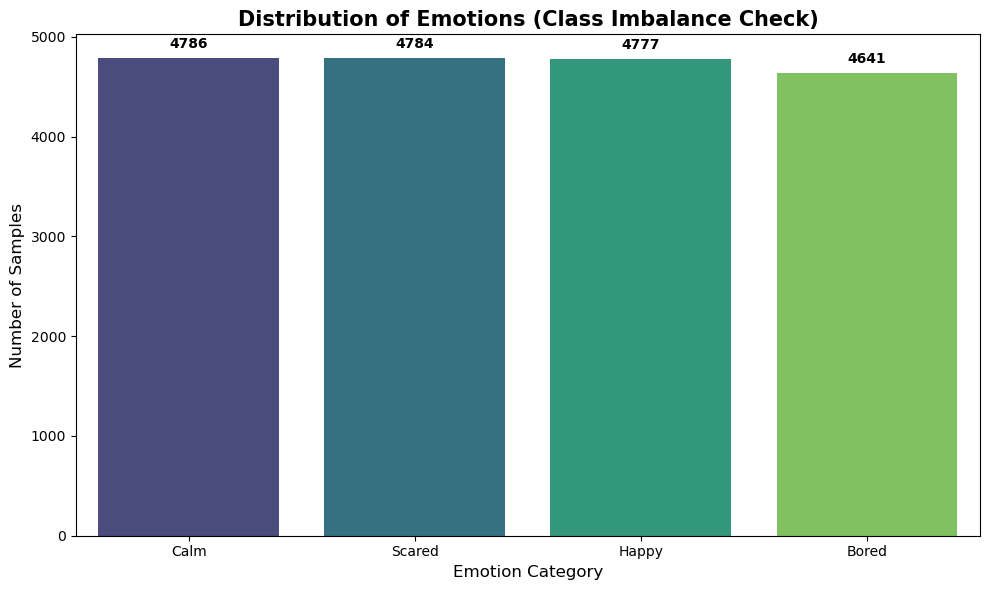

In [88]:
plt.figure(figsize=(10, 6))

sns.countplot(
    x='Classification', 
    data=csvfile, 
    hue='Classification', 
    palette='viridis', 
    legend=False
)

# Title and labels
plt.title('Distribution of Emotions (Class Imbalance Check)', fontsize=15, fontweight='bold')
plt.xlabel('Emotion Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

# Counts on top of the bars
counts = csvfile['Classification'].value_counts()

for i, label in enumerate(counts.index):
    count = counts[label]
    plt.text(i, count + 100, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Emotions are evenly distributed

### 2.2.3 Skew

Using skew, plotting histogram and density plot to find out skewness to determine which scaler to use

***Skew***

In [89]:
numerical_data.skew()

RAW_TP9    -0.608259
RAW_AF7     0.537695
RAW_AF8    -0.204649
RAW_TP10   -0.420753
dtype: float64

***Histogram for Numerical Features***

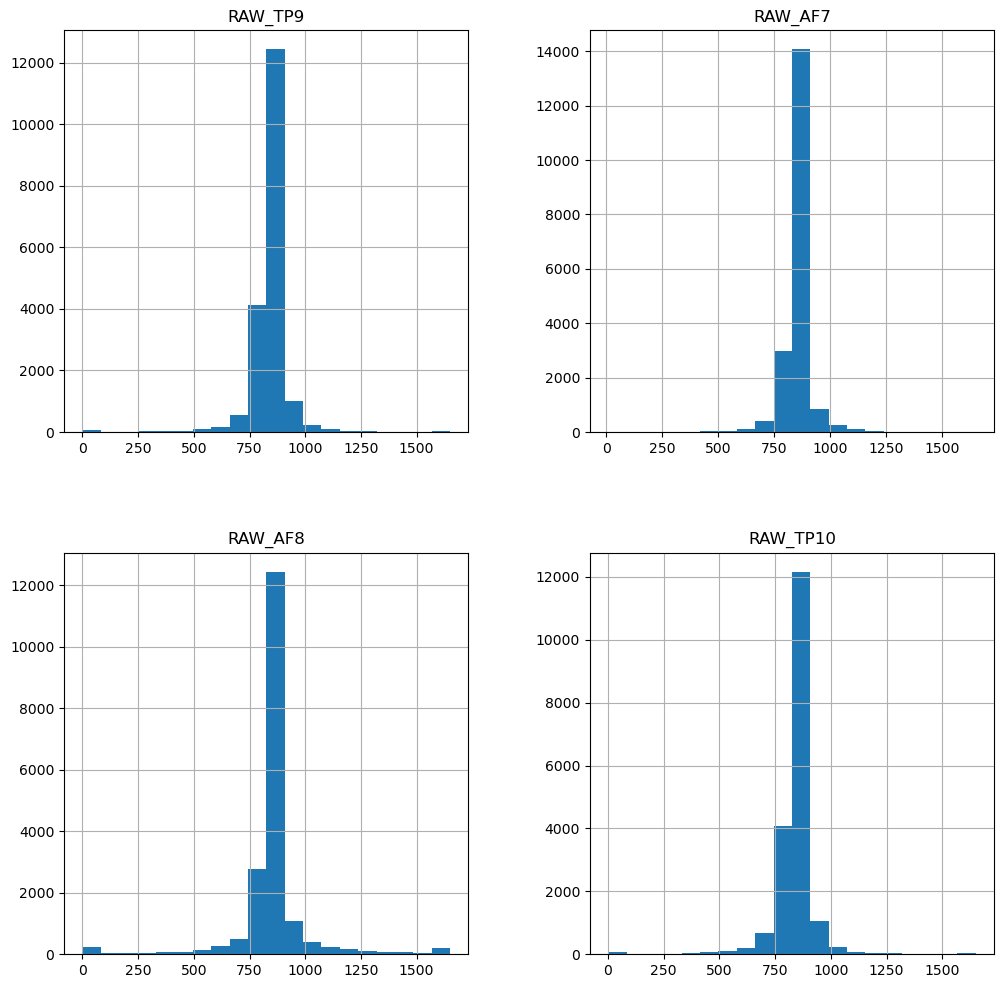

In [90]:
numerical_data.hist(figsize=(12,12),bins=20)
plt.show()

***Density Plot for Numerical Features***

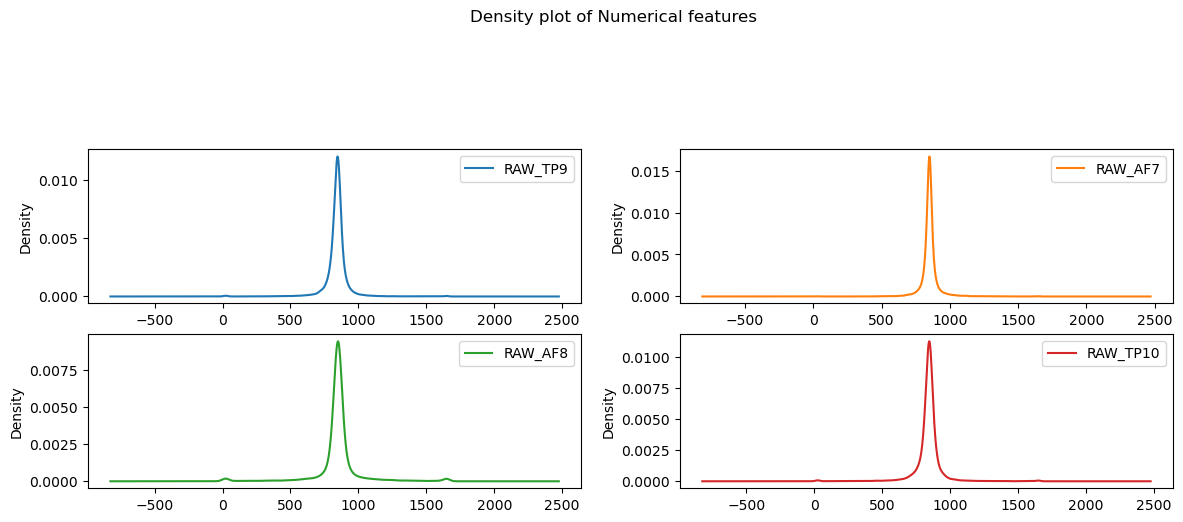

In [91]:
numerical_data.plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

***Verdict***

We should use Robust Scaler

## 2.3 Feature Correlation

***Correlation Matrix***

In [92]:
correlation_matrix = numerical_data.corr()
correlation_matrix

,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
RAW_TP9,1.000000,0.119619,0.011483,0.480414
RAW_AF7,0.119619,1.000000,0.123385,0.095268
RAW_AF8,0.011483,0.123385,1.000000,0.001759
RAW_TP10,0.480414,0.095268,0.001759,1.000000


***Heatmap for Correlation Matrix***

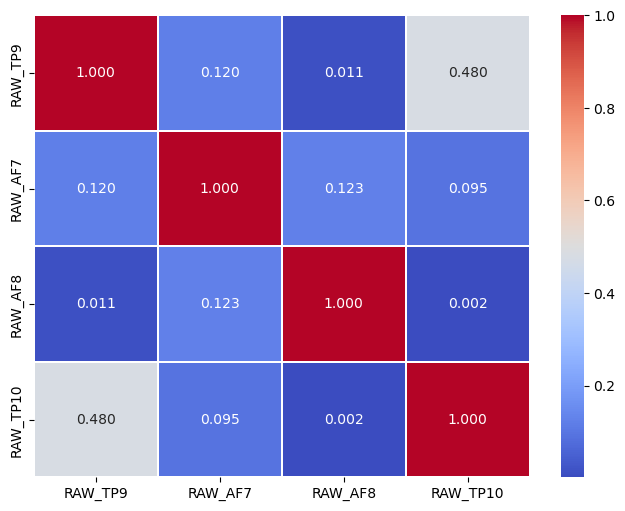

In [93]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.3)
plt.show()

No linear relationship between the EEG Signals

# **3. Modeling & Feature Extraction**

## 3.1 Label encoding + feature/target definition

### 3.1.1 Label Encoding
Label Encoding the Classification and Participant column to numbers

In [94]:
csvfile['Classification'] = pd.factorize(csvfile['Classification'])[0]
csvfile['Participant'] = pd.factorize(csvfile['Participant'])[0]

In [95]:
csvfile

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,0,0,848.16850,838.49817,861.86810,865.49450
1,0,0,840.51280,851.79486,847.36260,844.94507
2,0,0,819.96340,823.18680,815.53110,833.26010
3,0,0,838.09520,842.12450,848.97437,850.58606
4,0,0,849.78020,849.78020,829.63370,838.49817
...,...,...,...,...,...,...
18983,30,3,865.89746,836.48350,858.24176,877.17950
18984,30,3,874.76190,857.43590,831.24540,896.92310
18985,30,3,906.99634,897.72894,925.53110,939.63370
18986,30,3,795.38464,823.99270,979.12085,731.72160


### 3.1.2 Input and Output Split
Making the EEG Signals Input and Participant and Column be the Output

In [96]:
# X = Input features, Y = Output label
# Keep Participant separately (Windowing later)

feature_cols = csvfile.drop(columns=['Classification', 'Participant']).columns.tolist()

x = csvfile[feature_cols]
y = csvfile['Classification']

print('Feature columns used for ML:', feature_cols)

Feature columns used for ML: ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']


## 3.2 Windowing + Welch bandpower features

This section creates window-level features from raw EEG channels (TP9, AF7, AF8, TP10) in a **leakage-safe** way:

- **LOSO split first**: we hold out an entire Participant before creating any windows/features.
- **Per-split cleaning**: after splitting, we coerce EEG columns to numeric and drop invalid rows **separately** for train vs test.
- **Frequency bands**: delta (1–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), gamma (30–45 Hz).
- **Welch PSD**: estimates power spectral density for each sliding window, then integrates power in each band.
- **Sliding windows**: window length `win=64` samples, step `step=16` samples (overlap).
- **Output features**: 4 channels × 5 bands = **20 bandpower features** per window (log-transformed).

Note: windows are generated **within each Participant×Class segment** and **never mixed across train/test**, preventing overlap/time-series leakage.

### 3.2.1 Windowed EEG Feature Extraction

In [130]:
eeg_cols = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']

fs_hz = 256  # For frequency axis of Welch
window_samples = 64   # Multiple windows per segment (~154 rows each)
step_samples = 16
win = int(window_samples)
step = int(step_samples)

bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta' : (13, 30),
    'gamma': (30, 45),
}

def bandpower_welch(x_1d: np.ndarray, fs: int, fmin: float, fmax: float) -> float:
    nperseg = min(256, int(x_1d.shape[0]))
    if nperseg < 16:
        return 0.0
    nfft = 256
    f, pxx = welch(
        x_1d, fs=fs, nperseg=nperseg, noverlap=nperseg // 2, nfft=nfft
    )
    mask = (f >= fmin) & (f < fmax)
    if not np.any(mask):
        return 0.0
    return float(np.trapz(pxx[mask], f[mask]))

# -----------------------------------------------------------------------------
# Leakage-safe workflow:
# 1) LOSO split happens here on raw rows by Participant.
# 2) Cleaning is applied AFTER splitting, separately for train vs test.
# 3) Windowing + feature extraction are run separately on train vs test.
# 4) Any scaling/normalization is fit on train only in later cells.
# -----------------------------------------------------------------------------

required_cols = set(['Participant', 'Classification', *eeg_cols])
missing = required_cols.difference(csvfile.columns)
if missing:
    raise ValueError(f"Missing required columns: {sorted(missing)}")

# Fixed, global label schema (stable IDs; does not use test-set statistics)
if np.issubdtype(csvfile['Classification'].dtype, np.number):
    csvfile['Classification_id'] = csvfile['Classification'].astype(int)
    class_names = None
else:
    class_names = sorted(csvfile['Classification'].dropna().unique().tolist())
    class_to_id = {name: i for i, name in enumerate(class_names)}
    csvfile['Classification_id'] = csvfile['Classification'].map(class_to_id).astype(int)

# Stable participant ids for grouping/splitting
if np.issubdtype(csvfile['Participant'].dtype, np.number):
    csvfile['Participant_id'] = csvfile['Participant'].astype(int)
    participant_names = None
else:
    participant_names = sorted(csvfile['Participant'].dropna().unique().tolist())
    participant_to_id = {name: i for i, name in enumerate(participant_names)}
    csvfile['Participant_id'] = csvfile['Participant'].map(participant_to_id).astype(int)

participants = np.asarray(sorted(csvfile['Participant_id'].unique().tolist()), dtype=int)
if participants.size < 2:
    raise ValueError(f"Need at least 2 participants for LOSO, got {participants.size}")

# Choose which participant to hold out (fold index)
LOSO_FOLD = int(globals().get('LOSO_FOLD', 0))
_fold_to_use = int(LOSO_FOLD % participants.size)
heldout_pid = int(participants[_fold_to_use])

train_raw = csvfile.loc[csvfile['Participant_id'] != heldout_pid].reset_index(drop=True)
test_raw = csvfile.loc[csvfile['Participant_id'] == heldout_pid].reset_index(drop=True)

print(f"Using LOSO raw-row split: fold={_fold_to_use}/{participants.size-1}, held-out Participant_id={heldout_pid}")
print('Raw split shapes:', 'train_raw:', train_raw.shape, 'test_raw:', test_raw.shape)
print('Using win=', win, 'step=', step)


def clean_after_split(df: pd.DataFrame) -> pd.DataFrame:
    """Strict, split-local cleaning (prevents any cross-split influence)."""
    out = df.copy()

    # Convert any remaining '#NUM!' strings to NaN
    out = out.replace('#NUM!', np.nan)

    # Ensure EEG columns are numeric
    for c in eeg_cols:
        out[c] = pd.to_numeric(out[c], errors='coerce')

    # Drop rows missing required values (done per split)
    out = out.dropna(subset=eeg_cols + ['Participant_id', 'Classification_id']).reset_index(drop=True)

    # Ensure types
    out['Participant_id'] = out['Participant_id'].astype(int)
    out['Classification_id'] = out['Classification_id'].astype(int)

    return out


train_raw = clean_after_split(train_raw)
test_raw = clean_after_split(test_raw)
print('After per-split cleaning:', 'train_raw:', train_raw.shape, 'test_raw:', test_raw.shape)


def build_windowed_features(df: pd.DataFrame):
    feature_rows = []
    y = []
    groups = []
    seq_windows = []

    group_cols = ['Participant_id', 'Classification_id']

    seg_lengths = [len(g) for _, g in df.groupby(group_cols, sort=False)]
    if len(seg_lengths) > 0:
        print('Segment length summary (rows per Participant×Class):')
        print(pd.Series(seg_lengths).describe())

    for (pid, class_id), g in df.groupby(group_cols, sort=False):
        eeg = g[eeg_cols].to_numpy(dtype=np.float32)
        n = eeg.shape[0]
        if n < win:
            continue
        for start in range(0, n - win + 1, step):
            seg = eeg[start:start + win]  # (win, 4)
            if not np.isfinite(seg).all():
                continue

            feats = {}
            for ch_name in eeg_cols:
                xch = seg[:, eeg_cols.index(ch_name)]
                for bname, (fmin, fmax) in bands.items():
                    bp = bandpower_welch(xch, fs_hz, fmin, fmax)
                    feats[f"{ch_name}_{bname}"] = np.log10(bp + 1e-12)

            feature_rows.append(feats)
            y.append(int(class_id))
            groups.append(int(pid))
            seq_windows.append(seg)

    x_band = pd.DataFrame(feature_rows)
    X_seq = np.stack(seq_windows, axis=0).astype(np.float32) if len(seq_windows) else np.empty((0, win, len(eeg_cols)), dtype=np.float32)
    y = np.asarray(y, dtype=np.int32)
    groups = np.asarray(groups, dtype=np.int32)

    return x_band, X_seq, y, groups


# Build windows separately per split (prevents overlap/time leakage across splits)
x_band_train, X_train_seq, y_train_arr, groups_train = build_windowed_features(train_raw)
x_band_test, X_test_seq, y_test_arr, groups_test = build_windowed_features(test_raw)

print('Built TRAIN windowed dataset:')
print('x_band_train:', x_band_train.shape, 'X_train_seq:', X_train_seq.shape, 'y_train:', y_train_arr.shape)
print('Train class counts:', pd.Series(y_train_arr).value_counts().sort_index().to_dict())

print('Built TEST windowed dataset:')
print('x_band_test:', x_band_test.shape, 'X_test_seq:', X_test_seq.shape, 'y_test:', y_test_arr.shape)
print('Test class counts:', pd.Series(y_test_arr).value_counts().sort_index().to_dict())

# Backwards-compatible combined variables (for plotting/EDA only)
x_band = pd.concat([x_band_train, x_band_test], ignore_index=True)
X_seq_all = np.concatenate([X_train_seq, X_test_seq], axis=0) if (X_train_seq.size and X_test_seq.size) else (X_train_seq if X_train_seq.size else X_test_seq)
y_band = np.concatenate([y_train_arr, y_test_arr], axis=0)
groups_win = np.concatenate([groups_train, groups_test], axis=0)

Using LOSO raw-row split: fold=0/30, held-out Participant_id=0
Raw split shapes: train_raw: (18382, 8) test_raw: (606, 8)
Using win= 64 step= 16
After per-split cleaning: train_raw: (18382, 8) test_raw: (606, 8)
Segment length summary (rows per Participant×Class):
count    120.000000
mean     153.183333
std        3.832596
min      125.000000
25%      154.000000
50%      154.000000
75%      155.000000
max      158.000000
dtype: float64
Segment length summary (rows per Participant×Class):
count      4.0
mean     151.5
std        5.0
min      144.0
25%      151.5
50%      154.0
75%      154.0
max      154.0
dtype: float64
Built TRAIN windowed dataset:
x_band_train: (716, 20) X_train_seq: (716, 64, 4) y_train: (716,)
Train class counts: {0: 180, 1: 180, 2: 180, 3: 176}
Built TEST windowed dataset:
x_band_test: (24, 20) X_test_seq: (24, 64, 4) y_test: (24,)
Test class counts: {0: 6, 1: 6, 2: 6, 3: 6}


In [100]:
# Feature engineering on windowed data (leakage-safe)
# Builds additional features from per-split bandpowers and raw sequences.

if 'x_band_train' not in globals() or 'x_band_test' not in globals():
    raise NameError('Expected x_band_train/x_band_test from the windowing cell')
if 'X_train_seq' not in globals() or 'X_test_seq' not in globals():
    raise NameError('Expected X_train_seq/X_test_seq from the windowing cell')
if 'y_train_arr' not in globals() or 'y_test_arr' not in globals():
    raise NameError('Expected y_train_arr/y_test_arr from the windowing cell')


def engineer_features(x_band_in: pd.DataFrame, X_seq_in: np.ndarray) -> pd.DataFrame:
    x_feat = x_band_in.copy()
    eps = 1e-12

    # ---- Relative bandpowers + ratios (computed in linear domain) ----
    for ch in ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']:
        band_cols = [f"{ch}_{b}" for b in ['delta','theta','alpha','beta','gamma'] if f"{ch}_{b}" in x_feat.columns]
        if len(band_cols) != 5:
            continue

        bp_lin = np.stack([(10 ** x_feat[c].to_numpy(dtype=np.float64) - eps) for c in band_cols], axis=1)
        bp_lin = np.clip(bp_lin, 0.0, None)
        total = bp_lin.sum(axis=1, keepdims=True) + eps
        rel = bp_lin / total

        for i, b in enumerate(['delta','theta','alpha','beta','gamma']):
            x_feat[f"{ch}_{b}_rel"] = rel[:, i].astype(np.float32)
            x_feat[f"{ch}_{b}_logrel"] = np.log10(rel[:, i] + eps).astype(np.float32)

        def _col(bname: str) -> np.ndarray:
            return bp_lin[:, ['delta','theta','alpha','beta','gamma'].index(bname)]

        alpha = _col('alpha'); beta = _col('beta'); theta = _col('theta'); delta = _col('delta')
        x_feat[f"{ch}_alpha_beta"] = (alpha + eps) / (beta + eps)
        x_feat[f"{ch}_theta_beta"] = (theta + eps) / (beta + eps)
        x_feat[f"{ch}_abd_ttd"] = (alpha + beta + eps) / (theta + delta + eps)
        x_feat[f"{ch}_log_alpha_beta"] = np.log10((alpha + eps) / (beta + eps))
        x_feat[f"{ch}_log_theta_beta"] = np.log10((theta + eps) / (beta + eps))
        x_feat[f"{ch}_log_abd_ttd"] = np.log10((alpha + beta + eps) / (theta + delta + eps))

    # ---- Simple time-domain stats from raw window sequences ----
    Xw = np.asarray(X_seq_in, dtype=np.float32)
    if Xw.ndim != 3 or Xw.shape[0] != len(x_feat):
        raise ValueError(f"X_seq shape mismatch: X_seq={Xw.shape}, x_feat_rows={len(x_feat)}")

    ch_names = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']
    means = Xw.mean(axis=1)
    stds = Xw.std(axis=1)
    ptp = Xw.max(axis=1) - Xw.min(axis=1)
    rms = np.sqrt(np.mean(np.square(Xw), axis=1))
    absmean = np.mean(np.abs(Xw), axis=1)

    for i, ch in enumerate(ch_names):
        x_feat[f"{ch}_td_mean"] = means[:, i]
        x_feat[f"{ch}_td_std"] = stds[:, i]
        x_feat[f"{ch}_td_ptp"] = ptp[:, i]
        x_feat[f"{ch}_td_rms"] = rms[:, i]
        x_feat[f"{ch}_td_absmean"] = absmean[:, i]

    # ---- Asymmetry features (AF7 vs AF8) ----
    for b in ['delta','theta','alpha','beta','gamma']:
        c1 = f"RAW_AF7_{b}"
        c2 = f"RAW_AF8_{b}"
        if c1 in x_feat.columns and c2 in x_feat.columns:
            x_feat[f"AF7_minus_AF8_{b}"] = (x_feat[c1] - x_feat[c2]).astype(np.float32)
            x_feat[f"AF7_over_AF8_{b}"] = (10 ** x_feat[c1] + eps) / (10 ** x_feat[c2] + eps)
            x_feat[f"log_AF7_over_AF8_{b}"] = np.log10(x_feat[f"AF7_over_AF8_{b}"] + eps).astype(np.float32)

    return x_feat


# Engineer features separately per split (still no learned params)
X_train = engineer_features(x_band_train, X_train_seq).reset_index(drop=True)
X_test = engineer_features(x_band_test, X_test_seq).reset_index(drop=True)

y_train = pd.Series(y_train_arr)
y_test = pd.Series(y_test_arr)

print('Enhanced TRAIN features:', X_train.shape, 'y_train:', y_train.shape)
print('Enhanced TEST  features:', X_test.shape, 'y_test :', y_test.shape)

# Optional: keep combined engineered x_band for quick EDA plots
x_band = pd.concat([X_train, X_test], ignore_index=True)

Enhanced TRAIN features: (716, 119) y_train: (716,)
Enhanced TEST  features: (24, 119) y_test : (24,)


# **4. Scaling (Train-only)**

The train/test split is already applied **before windowing** using LOSO (participant-disjoint).
Here we only scale the engineered tabular features using a scaler **fit on training windows only**, then apply it to the held-out participant’s windows.

In [131]:
# Scaling (fit on LOSO train only)
##
# Downstream classical ML cells expect X_train_scaled / X_test_scaled.

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Scaled:', X_train_scaled.shape, X_test_scaled.shape)

Scaled: (716, 119) (24, 119)


Change the value of `LOSO_FOLD` (an integer from 0 to number_of_participants−1) to hold out a different participant.

`X_train`: engineered tabular features per window (bandpower + stats). Shape like (n_windows, n_features). <br>
`X_train_scaled`: the same features, but scaled using the scaler fit on the LOSO training windows only (correct for Logistic Regression / SVM / KNN / MLP). <br>
`X_train_seq`: raw EEG window sequences (time series). Shape like (n_windows, timesteps, 4). This is for deep/sequence models (CNN/RNN/EEGNet/Transformer). <br>

# **5. Classical ML Models (Tabular Features)**

Baselines trained on engineered bandpower features (after scaling).

## 5.1 ROC and AUC

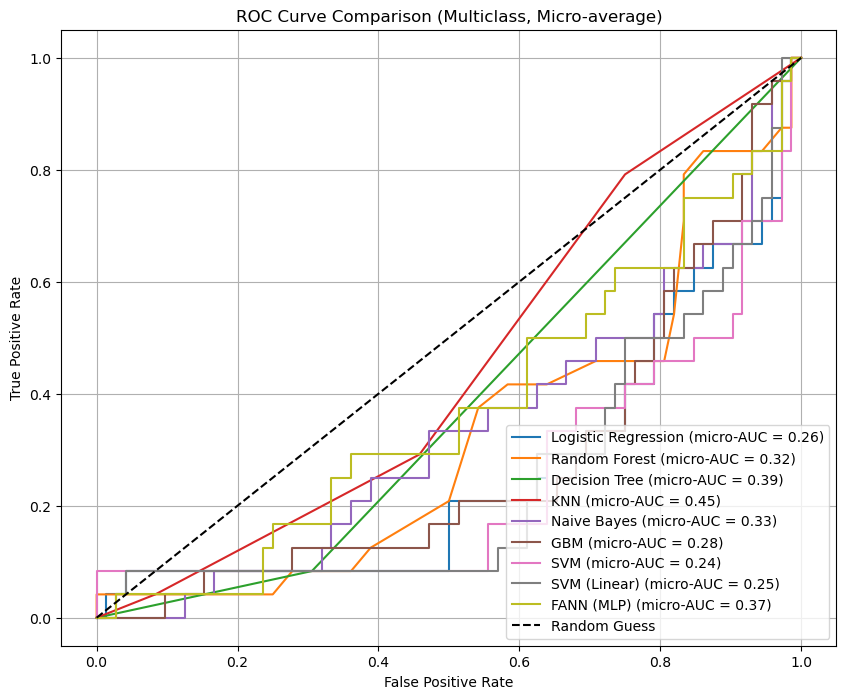

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        max_iter=5000,
        solver='lbfgs',
    ),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=5),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "GBM": GradientBoostingClassifier(random_state=5),
    "SVM": SVC(kernel='linear', class_weight='balanced', random_state=5),
    "SVM (Linear)": LinearSVC(
        class_weight='balanced',
        random_state=5,
        max_iter=10000,
        dual=False,
    ),
    "FANN (MLP)": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=300,
        early_stopping=True,
        random_state=5,
    ),
}

# Backwards-compatible outputs used later in the notebook
classic_acc = {}
classic_models = {}

def get_score_matrix(fitted_model, X):
    # Prefer probabilities when available; fall back to decision_function (e.g., LinearSVC)
    if hasattr(fitted_model, "predict_proba"):
        scores = fitted_model.predict_proba(X)
    elif hasattr(fitted_model, "decision_function"):
        scores = fitted_model.decision_function(X)
    else:
        raise ValueError(f"Model {type(fitted_model).__name__} has neither predict_proba nor decision_function")

    scores = np.asarray(scores)
    if scores.ndim == 1:
        # Binary case: convert (n_samples,) -> (n_samples, 1) for consistent ravel() behavior
        scores = scores.reshape(-1, 1)
    return scores

plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    classic_models[name] = model

    # Accuracy + predictions (used later for reports)
    y_pred = model.predict(X_test_scaled)
    classic_acc[name] = accuracy_score(y_test, y_pred)

    # Create legacy variable names expected later in the notebook
    if name == "Logistic Regression":
        logistic_model = model
        y_prediction = y_pred
        log_acc = classic_acc[name]
    elif name == "Decision Tree":
        dt_model = model
        y_pred_dt = y_pred
        dt_acc = classic_acc[name]
    elif name == "KNN":
        knn_model = model
        y_pred_knn = y_pred
        knn_acc = classic_acc[name]
    elif name == "Naive Bayes":
        nb_model = model
        y_pred_nb = y_pred
        nb_acc = classic_acc[name]
    elif name == "GBM":
        gbm_model = model
        y_pred_gbm = y_pred
        gbm_acc = classic_acc[name]
    elif name == "FANN (MLP)":
        fann_model = model
        y_pred_fann = y_pred
        fann_acc = classic_acc[name]
    elif name == "SVM":
        svm_model = model
        y_pred_svm = y_pred
        svm_svc_acc = classic_acc[name]
    elif name == "SVM (Linear)":
        svm_linear_model = model
        y_pred_svm_linear = y_pred
        svm_linear_acc = classic_acc[name]
        # historically `svm_acc` is used for the linear variant
        svm_acc = svm_linear_acc

    # ROC scores
    y_score = get_score_matrix(model, X_test_scaled)  # (n_samples, n_classes) or (n_samples, 1)

    # Binarize y_test using the model's class order to align columns
    y_test_bin = label_binarize(y_test, classes=model.classes_)

    # Micro-average ROC (treat each class prediction as a binary decision)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (micro-AUC = {roc_auc:.2f}, acc = {classic_acc[name]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Multiclass, Micro-average)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Quick accuracy summary
print('Classical model accuracies:')
for name, acc_ in sorted(classic_acc.items(), key=lambda kv: kv[1], reverse=True):
    print(f"- {name}: {acc_:.4f}")

## 5.10 Neural Networks
Using X_train_scaled / X_test_scaled

In [ ]:
## Build one-hot targets
y_train_np = np.asarray(y_train, dtype=np.int32)
y_test_np = np.asarray(y_test, dtype=np.int32)

# Use the global label schema (no need to peek at y_test distribution)
if 'Classification_id' in csvfile.columns:
    num_classes = int(csvfile['Classification_id'].nunique())
else:
    num_classes = int(np.max(y_train_np) + 1)
print('num_classes =', num_classes)

y_train_cat = tf.keras.utils.to_categorical(y_train_np, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test_np, num_classes=num_classes)

# Participant-disjoint validation split (avoid overlapping-window leakage across val/train)
X_nn_train = X_train_scaled
y_nn_train = y_train_cat
X_nn_val = None
y_nn_val = None

if 'groups_train' in globals():
    groups_train_nn = np.asarray(groups_train)
    if len(groups_train_nn) == X_train_scaled.shape[0]:
        unique_pids = np.unique(groups_train_nn)
        if unique_pids.size >= 2:
            VAL_PARTICIPANT = int(globals().get('VAL_PARTICIPANT', -1))
            if VAL_PARTICIPANT in unique_pids:
                val_pid = int(VAL_PARTICIPANT)
            else:
                VAL_FOLD = int(globals().get('VAL_FOLD', 0))
                val_pid = int(unique_pids[VAL_FOLD % unique_pids.size])
            val_mask = (groups_train_nn == val_pid)
            if val_mask.any() and (~val_mask).any():
                X_nn_train = X_train_scaled[~val_mask]
                y_nn_train = y_train_cat[~val_mask]
                X_nn_val = X_train_scaled[val_mask]
                y_nn_val = y_train_cat[val_mask]
                print(f"Dense NN validation: held-out Participant_id={val_pid} (val windows={val_mask.sum()}, train windows={(~val_mask).sum()})")

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

fit_kwargs = dict(
    x=X_nn_train,
    y=y_nn_train,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
 )
if X_nn_val is not None:
    fit_kwargs['validation_data'] = (X_nn_val, y_nn_val)
else:
    # Fallback if groups_train isn't available (still train-only)
    fit_kwargs['validation_split'] = 0.15

history = model.fit(**fit_kwargs)

loss, nn_acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"Dense NN (regularized) Accuracy = {nn_acc:.4f}")

Epoch 1/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2336 - loss: 3.4207 - val_accuracy: 0.2870 - val_loss: 2.7003
Epoch 2/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2385 - loss: 3.3490 - val_accuracy: 0.2685 - val_loss: 2.6701
Epoch 3/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2434 - loss: 3.3251 - val_accuracy: 0.2593 - val_loss: 2.6537
Epoch 4/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2352 - loss: 3.3707 - val_accuracy: 0.2500 - val_loss: 2.6381
Epoch 5/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2467 - loss: 3.2989 - val_accuracy: 0.2778 - val_loss: 2.6285
Epoch 6/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2385 - loss: 3.2789 - val_accuracy: 0.2870 - val_loss: 2.6220
Epoch 7/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2434 - loss: 3.2988 - val_accuracy: 0.2870 - val_loss: 2.6178
Epoch 8/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2829 - loss: 3.1856 - val_accuracy: 0.2778 - 

# **6. Deep Learning Models (Raw Windows)**

Sequence/conv models trained on raw window tensors with per-channel normalization (fit on train only).

## 6.1 Setup
- Converts `X_train_seq`/`X_test_seq` to `float32` and reads `timesteps` + `n_channels`. <br>
- Normalizes the sequences per channel using mean/std computed on the training windows only (to avoid leakage). <br>
- Converts `y_train`/`y_test` to NumPy ints and sets `num_classes`. <br>
- Computes class weights from the training labels for imbalance. <br>
- Defines early stopping and a helper function `train_eval_keras(...)` that compiles, trains, and evaluates a Keras model on `X_train_seq`. <br>


In [ ]:
# Correct shape: (n_windows, timesteps, n_channels=4)

X_train_seq = np.asarray(X_train_seq, dtype=np.float32)
X_test_seq = np.asarray(X_test_seq, dtype=np.float32)
timesteps = int(X_train_seq.shape[1])
n_channels = int(X_train_seq.shape[2])
print('Sequence tensor shape:', X_train_seq.shape, '(timesteps=', timesteps, ', channels=', n_channels, ')')

# -------------------------------
# Participant-disjoint val split
# -------------------------------
X_val_seq = None
y_val_np = None
if 'groups_train' in globals():
    groups_train_seq = np.asarray(groups_train, dtype=np.int32)
    if len(groups_train_seq) == X_train_seq.shape[0]:
        unique_pids = np.unique(groups_train_seq)
        if unique_pids.size >= 2:
            VAL_PARTICIPANT = int(globals().get('VAL_PARTICIPANT', -1))
            if VAL_PARTICIPANT in unique_pids:
                val_pid = int(VAL_PARTICIPANT)
            else:
                VAL_FOLD = int(globals().get('VAL_FOLD', 0))
                val_pid = int(unique_pids[VAL_FOLD % unique_pids.size])
            val_mask = (groups_train_seq == val_pid)
            if val_mask.any() and (~val_mask).any():
                X_val_seq = X_train_seq[val_mask].copy()
                X_train_seq = X_train_seq[~val_mask].copy()
                y_val_np = np.asarray(y_train, dtype=np.int32)[val_mask].copy()
                print(f"Deep learning validation: held-out Participant_id={val_pid} (val windows={val_mask.sum()}, train windows={(~val_mask).sum()})")

# Normalize per-channel using TRAINING statistics only (prevents leakage into val/test)
seq_mean = X_train_seq.mean(axis=(0, 1), keepdims=True)
seq_std = X_train_seq.std(axis=(0, 1), keepdims=True) + 1e-6
X_train_seq = (X_train_seq - seq_mean) / seq_std
X_test_seq = (X_test_seq - seq_mean) / seq_std
if X_val_seq is not None:
    X_val_seq = (X_val_seq - seq_mean) / seq_std

y_train_np = np.asarray(y_train, dtype=np.int32)
if X_val_seq is not None:
    # keep y_train_np aligned with X_train_seq after removing the val participant
    y_train_np = y_train_np[~val_mask]
y_test_np = np.asarray(y_test, dtype=np.int32)

# Number of classes from the fixed label schema (robust if a class is absent in the current training split)
if 'Classification_id' in csvfile.columns:
    num_classes = int(csvfile['Classification_id'].nunique())
else:
    num_classes = int(np.max(y_train_np) + 1)
print('num_classes =', num_classes)

# Class weights to mitigate imbalance (train labels only)
class_weights = None
classes = np.arange(num_classes, dtype=np.int32)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
print('class_weights:', class_weights)

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

def train_eval_keras(model, name: str, epochs: int = 60, batch_size: int = 64):
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
    )
    fit_kwargs = dict(
        x=X_train_seq,
        y=y_train_np,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        class_weight=class_weights,
        verbose=0,
    )
    if X_val_seq is not None and y_val_np is not None:
        fit_kwargs['validation_data'] = (X_val_seq, y_val_np)
    else:
        # Fallback if groups_train isn't available (still train-only)
        fit_kwargs['validation_split'] = 0.1

    model.fit(**fit_kwargs)
    loss, acc = model.evaluate(X_test_seq, y_test_np, verbose=0)
    print(f"{name} Accuracy = {acc:.4f}")
    return acc

Sequence tensor shape: (716, 64, 4) (timesteps= 64 , channels= 4 )
num_classes = 4
class_weights: {0: 0.9944444444444445, 1: 0.9944444444444445, 2: 0.9944444444444445, 3: 1.0170454545454546}


## 6.2 DeepConvNet

In [ ]:
# Convert to 2D conv format: (batch, channels, samples, 1)
X_train_eeg = np.transpose(X_train_seq, (0, 2, 1))[:, :, :, None]
X_test_eeg = np.transpose(X_test_seq, (0, 2, 1))[:, :, :, None]
X_val_eeg = None
if 'X_val_seq' in globals() and X_val_seq is not None:
    X_val_eeg = np.transpose(X_val_seq, (0, 2, 1))[:, :, :, None]

n_channels = int(X_train_eeg.shape[1])
timesteps = int(X_train_eeg.shape[2])
num_classes = int(np.unique(y_train_np).size) if 'y_train_np' in globals() else int(csvfile['Classification_id'].nunique())

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

kernel_w = max(5, min(15, timesteps))
pool_w = 2 if timesteps >= 2 else 1

deepconvnet_model = Sequential([
    Input(shape=(n_channels, timesteps, 1)),
    Conv2D(25, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    # Mix information across channels
    Conv2D(25, (n_channels, 1), padding='valid', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Conv2D(50, (1, kernel_w), padding='same', use_bias=True),
    BatchNormalization(),
    Activation('elu'),
    AveragePooling2D((1, pool_w)),
    Dropout(0.5),

    Flatten(),
    Dense(num_classes, activation='softmax'),
])

deepconvnet_model.compile(optimizer=Adam(1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

fit_kwargs = dict(
    x=X_train_eeg,
    y=y_train_np,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0,
    class_weight=class_weights if 'class_weights' in globals() else None,
 )
if X_val_eeg is not None and 'y_val_np' in globals() and y_val_np is not None:
    fit_kwargs['validation_data'] = (X_val_eeg, y_val_np)
else:
    fit_kwargs['validation_split'] = 0.1

deepconvnet_model.fit(**fit_kwargs)
_, deepconvnet_acc = deepconvnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"DeepConvNet Accuracy = {deepconvnet_acc:.4f}")

DeepConvNet Accuracy = 0.1250


## 6.3 EEGNet

In [ ]:
# Convert to 2D conv format: (batch, channels, samples, 1) where channels=4, samples=timesteps
X_train_eeg = np.transpose(X_train_seq, (0, 2, 1))[:, :, :, None]
X_test_eeg = np.transpose(X_test_seq, (0, 2, 1))[:, :, :, None]
X_val_eeg = None
if 'X_val_seq' in globals() and X_val_seq is not None:
    X_val_eeg = np.transpose(X_val_seq, (0, 2, 1))[:, :, :, None]

n_channels = int(X_train_eeg.shape[1])
timesteps = int(X_train_eeg.shape[2])
num_classes = int(np.unique(y_train_np).size) if 'y_train_np' in globals() else int(csvfile['Classification_id'].nunique())

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

kern_len = max(8, min(64, timesteps))
F1 = 8
D = 2
F2 = F1 * D

inp = Input(shape=(n_channels, timesteps, 1))
x = Conv2D(F1, (1, kern_len), padding='same', use_bias=False)(inp)
x = BatchNormalization()(x)

# Spatial filtering across channels
x = DepthwiseConv2D((n_channels, 1), depth_multiplier=D, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = SeparableConv2D(F2, (1, max(3, kern_len // 2)), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = AveragePooling2D((1, max(1, timesteps // 8)))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
out = Dense(num_classes, activation='softmax')(x)
eegnet_model = tf.keras.Model(inputs=inp, outputs=out)

eegnet_model.compile(optimizer=Adam(1e-3), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

fit_kwargs = dict(
    x=X_train_eeg,
    y=y_train_np,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0,
    class_weight=class_weights if 'class_weights' in globals() else None,
 )
if X_val_eeg is not None and 'y_val_np' in globals() and y_val_np is not None:
    fit_kwargs['validation_data'] = (X_val_eeg, y_val_np)
else:
    fit_kwargs['validation_split'] = 0.1

eegnet_model.fit(**fit_kwargs)
_, eegnet_acc = eegnet_model.evaluate(X_test_eeg, y_test_np, verbose=0)
print(f"EEGNet Accuracy = {eegnet_acc:.4f}")

EEGNet Accuracy = 0.1667


## 6.4 Mambular
Inspired gated causal Conv1D stack (Keras 3 compatible)

In [117]:
# "Mambular"-inspired gated causal Conv1D stack (Keras 3 compatible)

class GLU(Layer):
    def call(self, inputs):
        a, b = tf.split(inputs, num_or_size_splits=2, axis=-1)
        return a * tf.sigmoid(b)

def mambular_block(x, d_model: int, kernel_size: int = 7, dropout: float = 0.2):
    h = Conv1D(filters=2 * d_model, kernel_size=kernel_size, padding='causal')(x)
    h = GLU()(h)
    h = Dropout(dropout)(h)
    h = Dense(d_model)(h)
    return Add()([x, h])

d_model_m = 64
inp = Input(shape=(timesteps, n_channels))
x = Dense(d_model_m)(inp)
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(7, timesteps))
x = LayerNormalization()(x)
x = mambular_block(x, d_model_m, kernel_size=min(15, timesteps))
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
out = Dense(num_classes, activation='softmax')(x)
mambular_model = Model(inp, out)

mambular_acc = train_eval_keras(mambular_model, 'Mambular')

Mambular Accuracy = 0.0833


## 6.5 Transformer
Transformer encoder over time (timesteps) with channel features

In [118]:
d_model = 64
num_heads = 4
ff_dim = 128

inp = Input(shape=(timesteps, n_channels))
x = Dense(d_model)(inp)

pos = tf.range(start=0, limit=timesteps, delta=1)
pos_emb = tf.keras.layers.Embedding(input_dim=timesteps, output_dim=d_model)(pos)
x = x + pos_emb
x = LayerNormalization()(x)

attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
x = Add()([x, attn_out])
x = LayerNormalization()(x)

ffn = Dense(ff_dim, activation='relu')(x)
ffn = Dropout(0.2)(ffn)
ffn = Dense(d_model)(ffn)
x = Add()([x, ffn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)
transformer_model = tf.keras.Model(inputs=inp, outputs=out)
transformer_acc = train_eval_keras(transformer_model, 'Transformer')

Transformer Accuracy = 0.0417


## 6.6 LSTM - Long Short-Term Memory

In [119]:
# LSTM (correct: timesteps=time, features=channels)
lstm_model = Sequential([
    Input(shape=(timesteps, n_channels)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax'),
])
lstm_acc = train_eval_keras(lstm_model, 'LSTM')

LSTM Accuracy = 0.1250


## 6.7 RNN - Recurrent Neural Network

In [120]:
# RNN (SimpleRNN) — correct: timesteps=time, features=channels
rnn_model = Sequential([
    Input(shape=(timesteps, n_channels)),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),
])
rnn_acc = train_eval_keras(rnn_model, 'RNN')

RNN Accuracy = 0.1667


## 6.8 Hybrid: **CNN** + **BiLSTM** with **Self-Attention**

In [121]:
# Hybrid model: CNN + BiLSTM with Self-Attention

k1 = min(7, int(timesteps))
k2 = min(5, int(timesteps))
stride2 = 2 if int(timesteps) >= 2 else 1

inp = Input(shape=(int(timesteps), int(n_channels)))
x = Conv1D(64, kernel_size=k1, padding='same', activation='relu')(inp)
x = Dropout(0.2)(x)
x = Conv1D(64, kernel_size=k2, padding='same', activation='relu', strides=stride2)(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.3)(x)

attn = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = Add()([x, attn])
x = LayerNormalization()(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
out = Dense(int(num_classes), activation='softmax')(x)

cnn_bilstm_attn_model = tf.keras.Model(inputs=inp, outputs=out)
cnn_bilstm_attn_acc = train_eval_keras(cnn_bilstm_attn_model, 'CNN-BiLSTM + Attention')

CNN-BiLSTM + Attention Accuracy = 0.1250


## 6.9 BERT

In [122]:
class CLSToken(Layer):
    def __init__(self, d_model: int, **kwargs):
        super().__init__(**kwargs)
        self.d_model = int(d_model)
        self.cls = None

    def build(self, input_shape):
        self.cls = self.add_weight(
            name='cls_token',
            shape=(1, 1, self.d_model),
            initializer='zeros',
            trainable=True,
        )
        super().build(input_shape)

    def call(self, x):
        batch = tf.shape(x)[0]
        cls_tokens = tf.tile(self.cls, [batch, 1, 1])
        return tf.concat([cls_tokens, x], axis=1)

def transformer_encoder(x, d_model: int, num_heads: int, ff_dim: int, dropout: float = 0.1):
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x)
    attn_out = Dropout(dropout)(attn_out)
    x = Add()([x, attn_out])
    x = LayerNormalization()(x)

    ffn = Dense(ff_dim, activation='relu')(x)
    ffn = Dropout(dropout)(ffn)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout)(ffn)
    x = Add()([x, ffn])
    x = LayerNormalization()(x)
    return x

# Hyperparams (kept small for speed)
bert_d_model = 64
bert_num_heads = 4
bert_ff_dim = 128
bert_num_layers = 2
bert_dropout = 0.15

inp = Input(shape=(int(timesteps), int(n_channels)))
x = Dense(bert_d_model)(inp)
x = CLSToken(bert_d_model)(x)

# Learnable positional embeddings for (CLS + timesteps) positions
pos_ids = tf.range(start=0, limit=int(timesteps) + 1, delta=1)
pos_emb = Embedding(input_dim=int(timesteps) + 1, output_dim=bert_d_model)(pos_ids)
x = x + pos_emb

x = Dropout(bert_dropout)(x)
for _ in range(bert_num_layers):
    x = transformer_encoder(x, d_model=bert_d_model, num_heads=bert_num_heads, ff_dim=bert_ff_dim, dropout=bert_dropout)

# CLS pooling
cls_vec = x[:, 0, :]
out = Dense(int(num_classes), activation='softmax')(cls_vec)
bert_model = Model(inp, out)

bert_acc = train_eval_keras(bert_model, 'BERT-style Transformer')

BERT-style Transformer Accuracy = 0.1250


# **7. Results summary**

Determining the accuracies

## 7.1 Accuracies

In [123]:
# Print accuracies (only for models that were run)

print('Classic Model Accuracies: \n')

print('Logistic Regression Accuracy    -', log_acc)
print('Decision Tree Accuracy          -', dt_acc)
print('KNN Accuracy                    -', knn_acc)
print('Naive Bayes Accuracy            -', nb_acc)
print('GBM Accuracy                    -', gbm_acc)
print('SVM (Linear) Accuracy           -', svm_acc)
print('FANN (MLP) Accuracy             -', fann_acc)
print('Neural Network (Dense) Accuracy -', nn_acc)

# Deep learning models (sequence models)

print('\nDeep Learning Models Accuracies: \n')

print('RNN Accuracy                    -', rnn_acc)
print('LSTM Accuracy                   -', lstm_acc)
print('Transformer Accuracy            -', transformer_acc)
print('Mambular Accuracy               -', mambular_acc)
print('EEGNet Accuracy                 -', eegnet_acc)
print('DeepConvNet Accuracy            -', deepconvnet_acc)
print('BERT-style Transformer Accuracy -', bert_acc)
print('CNN-BiLSTM + Attention Accuracy -', cnn_bilstm_attn_acc)

Classic Model Accuracies: 

Logistic Regression Accuracy    - 0.08333333333333333
Decision Tree Accuracy          - 0.125
KNN Accuracy                    - 0.16666666666666666
Naive Bayes Accuracy            - 0.08333333333333333
GBM Accuracy                    - 0.125
SVM (Linear) Accuracy           - 0.041666666666666664
FANN (MLP) Accuracy             - 0.16666666666666666
Neural Network (Dense) Accuracy - 0.1666666716337204

Deep Learning Models Accuracies: 

RNN Accuracy                    - 0.1666666716337204
LSTM Accuracy                   - 0.125
Transformer Accuracy            - 0.0416666679084301
Mambular Accuracy               - 0.0833333358168602
EEGNet Accuracy                 - 0.1666666716337204
DeepConvNet Accuracy            - 0.125
BERT-style Transformer Accuracy - 0.125
CNN-BiLSTM + Attention Accuracy - 0.125


## 7.2 Accuracy Comparison Chart

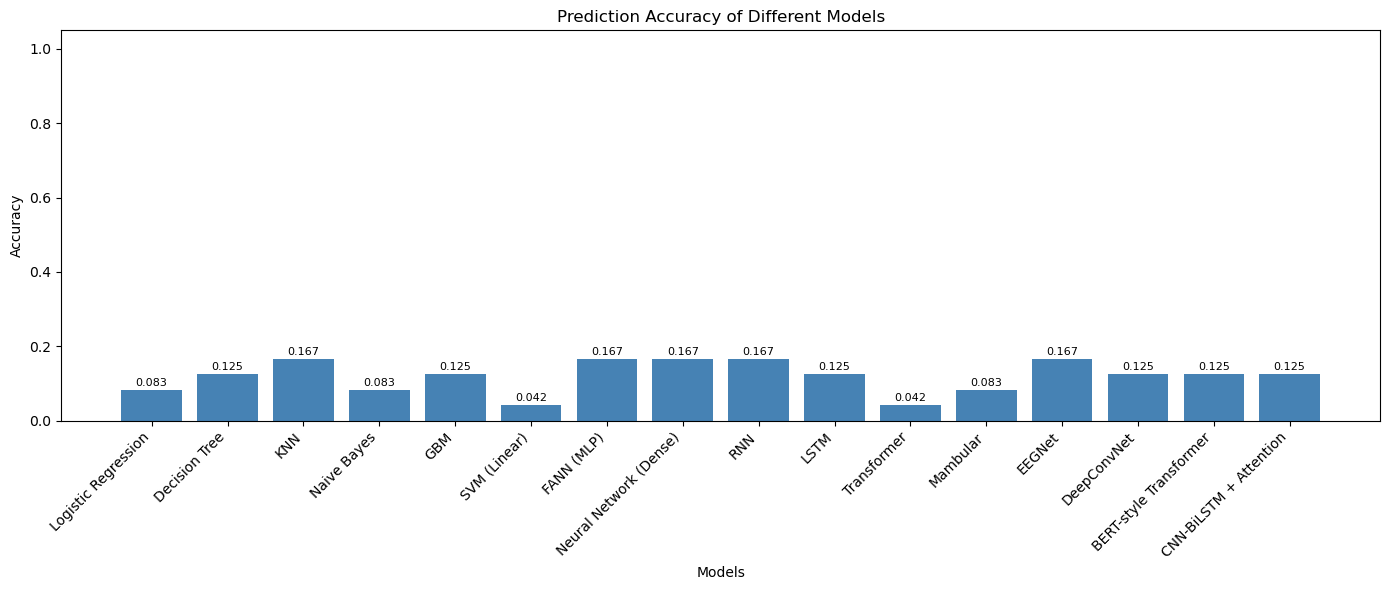

In [127]:
# Accuracy comparison across models (only include ones that exist)
model_acc = {}
for name, var in [
    ('Logistic Regression', 'log_acc'),
    ('Decision Tree', 'dt_acc'),
    ('KNN', 'knn_acc'),
    ('Naive Bayes', 'nb_acc'),
    ('GBM', 'gbm_acc'),
    ('SVM (Linear)', 'svm_acc'),
    ('FANN (MLP)', 'fann_acc'),
    ('Neural Network (Dense)', 'nn_acc'),
    ('RNN', 'rnn_acc'),
    ('LSTM', 'lstm_acc'),
    ('Transformer', 'transformer_acc'),
    ('Mambular', 'mambular_acc'),
    ('EEGNet', 'eegnet_acc'),
    ('DeepConvNet', 'deepconvnet_acc'),
    ('BERT-style Transformer', 'bert_acc'),
    ('CNN-BiLSTM + Attention', 'cnn_bilstm_attn_acc'),
 ]:
    if var in globals():
        model_acc[name] = float(globals()[var])

plt.figure(figsize=(14, 6))
names = list(model_acc.keys())
scores = list(model_acc.values())
bars = plt.bar(names, scores, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy of Different Models')

for b, s in zip(bars, scores):
    plt.text(b.get_x() + b.get_width()/2, s + 0.005, f'{s:.3f}', ha='center', va='bottom', fontsize=8)

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

## 7.3 Interpretation / Evaluation

In [128]:
# Interpretation / Evaluation (robust to stale variables)
y_test_arr = np.asarray(y_test)
labels = sorted(pd.Series(y_test_arr).unique())
target_names = [str(l) for l in labels]

def _report(name: str, y_pred):
    if y_pred is None:
        print(f"{name}: not available")
        return
    y_pred = np.asarray(y_pred)
    if len(y_pred) != len(y_test_arr):
        print(f"{name}: skipped (length mismatch y_test={len(y_test_arr)} vs y_pred={len(y_pred)})")
        return
    print(f"{name}:")
    print(classification_report(y_test_arr, y_pred, target_names=target_names, zero_division=0))
    print('------------------------------------------------------\n')

def _predict_from_keras(model_obj, X, name: str):
    if model_obj is None or X is None:
        return None
    if not hasattr(model_obj, 'predict'):
        return None
    try:
        probs = model_obj.predict(X, verbose=0)
        probs = np.asarray(probs)
        if probs.ndim == 1:
            # binary sigmoid-like output
            return (probs >= 0.5).astype(int)
        return np.argmax(probs, axis=1)
    except Exception as e:
        print(f"{name}: could not compute predictions: {e}")
        return None

# -----------------
# Classic ML models
# -----------------
_report('Logistic Regression', globals().get('y_prediction'))
_report('SVM (SVC linear)', globals().get('y_pred_svm'))
_report('Decision Tree', globals().get('y_pred_dt'))
_report('KNN', globals().get('y_pred_knn'))
_report('Naive Bayes', globals().get('y_pred_nb'))
_report('GBM', globals().get('y_pred_gbm'))
_report('FANN (MLP)', globals().get('y_pred_fann'))

# ----------------------
# Dense NN (tabular ML)
# ----------------------
dense_pred = None
if 'nn_pred' in globals() and len(np.asarray(nn_pred)) == len(y_test_arr):
    dense_pred = nn_pred
else:
    # Try to recompute using the latest Keras dense model if it exists
    if 'model' in globals() and hasattr(model, 'predict') and 'X_test_scaled' in globals():
        try:
            probs = model.predict(X_test_scaled, verbose=0)
            dense_pred = np.argmax(np.asarray(probs), axis=1)
        except Exception as e:
            print('Dense NN: could not recompute predictions:', e)
            dense_pred = None
_report('Neural Network (Dense)', dense_pred)

# -------------------------
# Deep learning (sequences)
# -------------------------
Xseq = globals().get('X_test_seq')
Xeeg = globals().get('X_test_eeg')
_report('RNN', _predict_from_keras(globals().get('rnn_model'), Xseq, 'RNN'))
_report('LSTM', _predict_from_keras(globals().get('lstm_model'), Xseq, 'LSTM'))
_report('Transformer', _predict_from_keras(globals().get('transformer_model'), Xseq, 'Transformer'))
_report('Mambular', _predict_from_keras(globals().get('mambular_model'), Xseq, 'Mambular'))
_report('CNN-BiLSTM + Attention', _predict_from_keras(globals().get('cnn_bilstm_attn_model'), Xseq, 'CNN-BiLSTM + Attention'))
_report('BERT-style Transformer', _predict_from_keras(globals().get('bert_model'), Xseq, 'BERT-style Transformer'))

# EEG-specific conv models (often use X_test_eeg if reshaped earlier)
_report('EEGNet', _predict_from_keras(globals().get('eegnet_model'), Xeeg, 'EEGNet'))
_report('DeepConvNet', _predict_from_keras(globals().get('deepconvnet_model'), Xeeg, 'DeepConvNet'))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.11      0.17      0.13         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.14      0.17      0.15         6

    accuracy                           0.08        24
   macro avg       0.06      0.08      0.07        24
weighted avg       0.06      0.08      0.07        24

------------------------------------------------------

SVM (SVC linear):
              precision    recall  f1-score   support

           0       0.11      0.17      0.13         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         6
           3       0.12      0.17      0.14         6

    accuracy                           0.08        24
   macro avg       0.06      0.08      0.07        24
weighted avg       0.06      0.08      0.07        24

-----------------------------------